In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("ransomeware_dataset.csv")

data.head()

,FileName,md5Hash,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
0,0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll,79755c51e413ed3c6be4635fd729a6e1,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
1,05c8318f98a5d301d80000009c316005.vertdll.dll,95e19f3657d34a432eada93221b0ea16,34404,84,121728,10,10,126576,4930,0,14,10,8,262144,16864,1024,0,1
2,06054fba-5619-4a86-a861-ffb0464bef5d.dll,85c32641d77a54e19ba8ea4ab305c791,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
3,075822ac99a5d301660400009c316005.adhapi.dll,62e3b959d982ef534b66f819fe15f085,34404,84,19904,10,10,21312,252,18160,14,10,6,262144,16736,1040,0,1
4,090607dd9ba5d301ca0900009c316005.SensorsNative...,ae38c5f7d313ad0ff3bfb8826476767f,34404,84,97728,10,10,105792,1852,70592,14,10,7,262144,16736,1096,0,1


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62485 entries, 0 to 62484
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   FileName            62485 non-null  object
 1   md5Hash             62485 non-null  object
 2   Machine             62485 non-null  int64 
 3   DebugSize           62485 non-null  int64 
 4   DebugRVA            62485 non-null  int64 
 5   MajorImageVersion   62485 non-null  int64 
 6   MajorOSVersion      62485 non-null  int64 
 7   ExportRVA           62485 non-null  int64 
 8   ExportSize          62485 non-null  int64 
 9   IatVRA              62485 non-null  int64 
 10  MajorLinkerVersion  62485 non-null  int64 
 11  MinorLinkerVersion  62485 non-null  int64 
 12  NumberOfSections    62485 non-null  int64 
 13  SizeOfStackReserve  62485 non-null  int64 
 14  DllCharacteristics  62485 non-null  int64 
 15  ResourceSize        62485 non-null  int64 
 16  BitcoinAddresses    62

In [4]:
X = data.drop(columns=['FileName', 'BitcoinAddresses', 'Benign','md5Hash'])
y = data['Benign']


In [5]:
data['Benign'].value_counts()


Benign
0    35367
1    27118
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

(49988, 14) (12497, 14)


In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=12)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Machine', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion',
       'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion',
       'MinorLinkerVersion', 'NumberOfSections', 'SizeOfStackReserve',
       'DllCharacteristics'],
      dtype='object')


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11)  
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print(X_train_pca.shape, X_test_pca.shape)

(49988, 11) (12497, 11)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(2048, activation='relu', input_dim=X_train_pca.shape[1]),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train_pca, y_train, 
                    validation_data=(X_test_pca, y_test),
                    epochs=45, 
                    batch_size=32, 
                    callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test_pca, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/45


c:\Users\aaaro\anaconda3\envs\ransome\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9213 - loss: 0.2232 - val_accuracy: 0.9732 - val_loss: 0.0993
Epoch 2/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9698 - loss: 0.1079 - val_accuracy: 0.9754 - val_loss: 0.0823
Epoch 3/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9737 - loss: 0.0948 - val_accuracy: 0.9774 - val_loss: 0.0822
Epoch 4/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9776 - loss: 0.0844 - val_accuracy: 0.9797 - val_loss: 0.0725
Epoch 5/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9770 - loss: 0.0815 - val_accuracy: 0.9790 - val_loss: 0.0694
Epoch 6/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9793 - loss: 0.0746 - val_accuracy: 0.9786 - val_loss: 0.0729
Epoch 7/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9796 - loss: 0.0727 - val_accuracy: 0.9794 - val_loss: 0.0645
Epoch 8/45
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9806 - loss: 0.06

In [11]:
y_pred = model.predict(X_test_pca)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7125
           1       0.98      0.99      0.99      5372

    accuracy                           0.99     12497
   macro avg       0.99      0.99      0.99     12497
weighted avg       0.99      0.99      0.99     12497

Confusion Matrix:
[[7019  106]
 [  55 5317]]


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


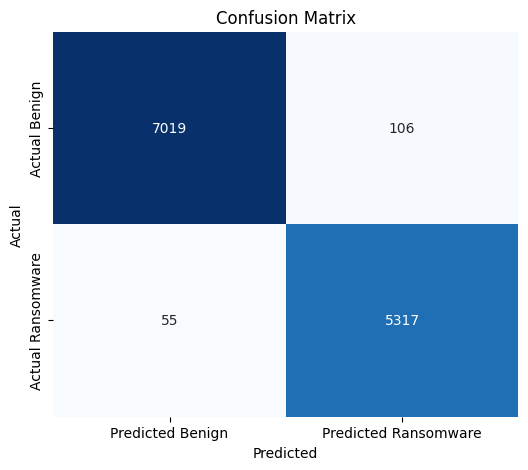

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_pca)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Benign', 'Predicted Ransomware'], 
            yticklabels=['Actual Benign', 'Actual Ransomware'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

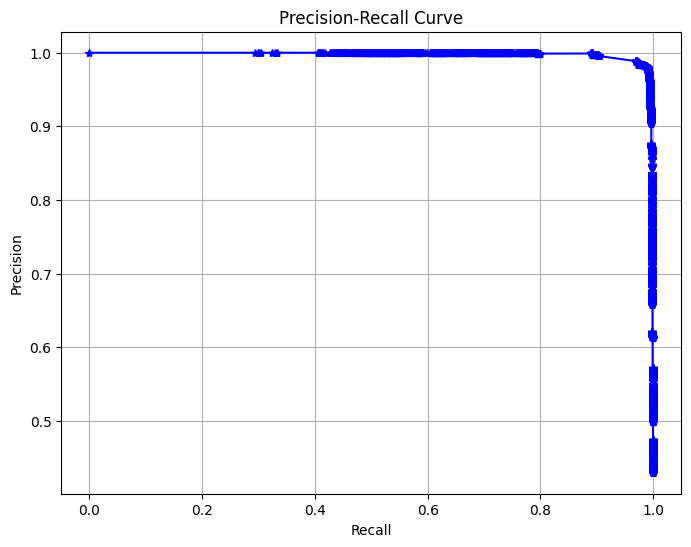

In [13]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, marker='*', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [14]:
model.save("ransomeware_prediction_model.h5")